In [1]:
import io, requests, glob, os
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.api import STLForecast
from statsmodels.tsa.arima.model import ARIMA


In [2]:
# Plot a parameter of a dataframe
def plot_param(params, title, data):
    params = params if type(params) in (tuple, list) else [params]
    maxDate = data["Datum"].max()
    fig, axs = plt.subplots(5, 2, figsize=(20, 20), constrained_layout=True)
    fig.suptitle(
        f'{title} bis {maxDate.strftime("%d. %b %Y")}',
        fontweight="bold", fontsize="xx-large")
    i = 0

    # Name is the name of the Bundesland. Create a figure for each country.
    for bl in data["Name"].unique():
        data_bl = data.loc[data["Name"] == bl]
        # Figure order: 0  1
        #               2  3 ...
        axis = axs[int(i / 2), i % 2]
        axis.xaxis.set_major_locator(mdates.MonthLocator())
        axis.xaxis.set_minor_locator(
            mdates.WeekdayLocator(byweekday=mdates.MO))
        axis.set_title(bl,
                       fontweight="bold" if bl == "Österreich" else "normal")
        j = 0
        secondAxis = axis.twinx() if len(params) > 1 else None
        # Draw a line for each parameter
        for param in params:
            currentAxis = axis if j == 0 else secondAxis
            res = STL(data_bl.loc[:, param], period=7).fit()
            if j == 0:
                currentAxis.plot(res.observed, linewidth=1)
                currentAxis.plot(res.trend)
            else:
                currentAxis.plot(res.trend, color="black", linewidth=1)
            j = j + 1
        axis.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
        axis.grid(True, which="minor", axis="x")
        axis.grid(True, which="major", axis="y")
        i = i + 1
        if bl == "Österreich":
            for a in ['top', 'bottom', 'left', 'right']:
                axis.spines[a].set_linewidth(2)
            #plt.rc("figure", figsize=(16, 8))
            #res.plot()
    plt.show()
    fig.savefig(f'{title}_{dt.datetime.now(dt.timezone.utc).strftime("%Y%m%d%H%M%S")}.png', facecolor="white", dpi=96)


In [3]:

requests.packages.urllib3.disable_warnings()
requests.packages.urllib3.util.ssl_.DEFAULT_CIPHERS += 'HIGH:!DH:!aNULL'

# To avoid ssl error (key to short) we use requests.get
req = requests.get(
    "https://info.gesundheitsministerium.gv.at/data/timeline-faelle-bundeslaender.csv", verify=False)
with open("timeline-faelle-bundeslaender.csv", "wb") as f:
    f.write(req.content)

# Read the result in a dataframe
data = pd.read_table(
    io.StringIO(req.content.decode("utf-8-sig")),
    sep=";", header=0, parse_dates=[0])

# Calculate the diff values. We have 10 Countries (9 + Austria in general)
# so the last value is 10 lines above.
data["TestungenPCRTaeglich"] = data["TestungenPCR"].diff(periods=10)
data["HospitalisierungTaeglich"] = data["Hospitalisierung"].diff(periods=10)
data["Neuinfektionen"] = data["BestaetigteFaelleBundeslaender"].diff(
    periods=10)
data["Positivrate"] = data.apply(lambda row: np.nan if row["TestungenPCRTaeglich"] == 0 else row["Neuinfektionen"] * 100000 / row["TestungenPCRTaeglich"], axis=1)
# Subtract 1 day (values are published on the next day in the morning)
data["Datum"] = pd.to_datetime(data["Datum"], utc=True).dt.date + pd.DateOffset(days=-1)
for bl in data["Name"].unique():
    # Basic outlier detection: remove values which are higher then the mean value + 5 * standard deviation
    for param in ["TestungenPCRTaeglich", "HospitalisierungTaeglich", "Hospitalisierung", "Neuinfektionen", "Positivrate"]:
        mean = data.loc[data["Name"] == bl, param].mean()
        stdev = data.loc[data["Name"] == bl, param].std()
        minVal = 0 if (param == "TestungenPCRTaeglich" or param ==
                       "Neuinfektionen" or param == "Positivrate") else mean - 5 * stdev
        maxVal = mean + 5 * stdev
        data.loc[(data["Name"] == bl) & ((data[param] < minVal)
                                         | (data[param] > maxVal)), param] = np.nan
    # Fill na values
    data.loc[data["Name"] == bl] = data.loc[data["Name"] == bl].fillna(method="bfill")
    data.loc[data["Name"] == bl] = data.loc[data["Name"] == bl].fillna(method="ffill")
data.to_csv("timeline-faelle-bundeslaender.csv", encoding='utf-8', index=False)


In [4]:
data = pd.read_csv("timeline-faelle-bundeslaender.csv",
                   encoding='utf-8', parse_dates=[0])
data.set_index("Datum", drop=False, inplace=True)
for file in glob.glob('*.png'):
    os.remove(file)


## Neuinfektionen

Die Neuinfektionen zeigen eine Abhängigkeit vom Wochentag, da am Wochenende weniger getestet wird. Zudem werden die Schultests an bestimmten Tagen durchgeführt.

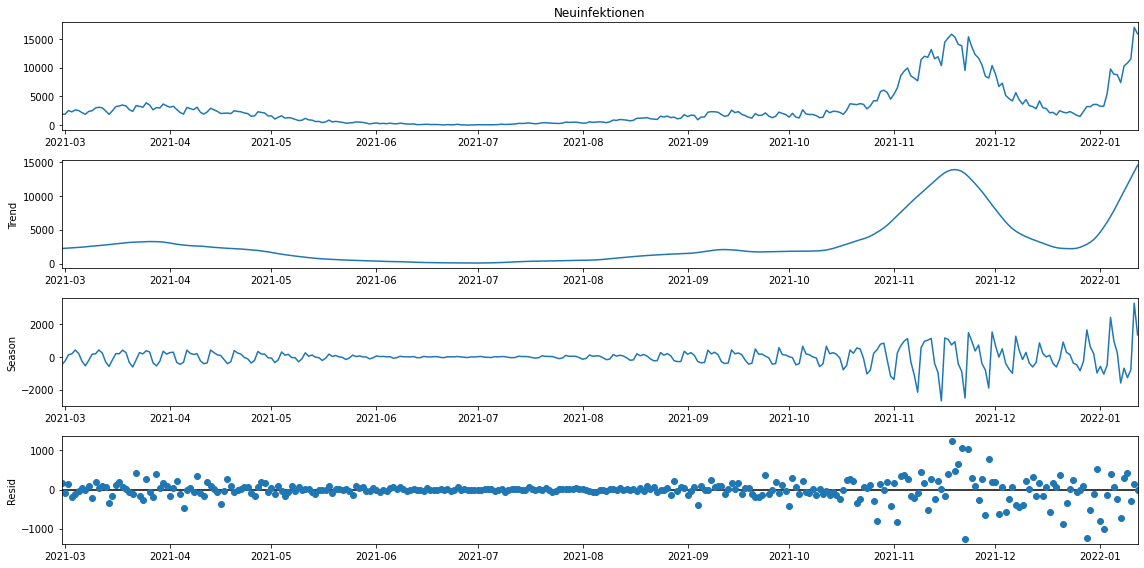

In [5]:
decomposed = STL(data.loc[data["Name"] == "Österreich", "Neuinfektionen"], period=7).fit()
plt.rc("figure", figsize=(16, 8))
decomposed.plot()
plt.show()


## Hospitalisierung
### Werte der letzten 7 Tage

In [6]:
data.tail(7*10).pivot(values="Hospitalisierung", columns="Name")


Name,Burgenland,Kärnten,Niederösterreich,Oberösterreich,Salzburg,Steiermark,Tirol,Vorarlberg,Wien,Österreich
Datum,,,,,,,,,,
2022-01-06,51.0,90.0,149.0,89.0,58.0,101.0,117.0,36.0,238.0,929.0
2022-01-07,45.0,89.0,138.0,85.0,57.0,97.0,120.0,34.0,255.0,920.0
2022-01-08,46.0,88.0,129.0,92.0,57.0,88.0,114.0,35.0,262.0,911.0
2022-01-09,45.0,95.0,125.0,98.0,56.0,86.0,117.0,41.0,272.0,935.0
2022-01-10,47.0,87.0,117.0,92.0,64.0,96.0,122.0,39.0,264.0,928.0
2022-01-11,44.0,87.0,114.0,91.0,63.0,96.0,113.0,29.0,272.0,909.0
2022-01-12,42.0,83.0,111.0,90.0,62.0,93.0,112.0,29.0,267.0,889.0


### Neuinfektionen (Vorausberechnung)

In [7]:
infektionen = data.loc[data["Name"] == "Österreich", "Neuinfektionen"].tail(14)
fcst = STLForecast(infektionen, ARIMA, period=7, model_kwargs={"order": (2, 1, 0)}).fit().forecast(10)
pd.DataFrame(fcst, columns = ["Neuinfektionen"])

C:\Python3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Python3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Python3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Python3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


,Neuinfektionen
2022-01-13,15031.142552
2022-01-14,13650.142247
2022-01-15,16536.141636
2022-01-16,17049.141026
2022-01-17,17761.140110
2022-01-18,23251.139194
2022-01-19,22097.137973
2022-01-20,21276.279609
2022-01-21,19895.278083
2022-01-22,22781.276556


### Diagramm

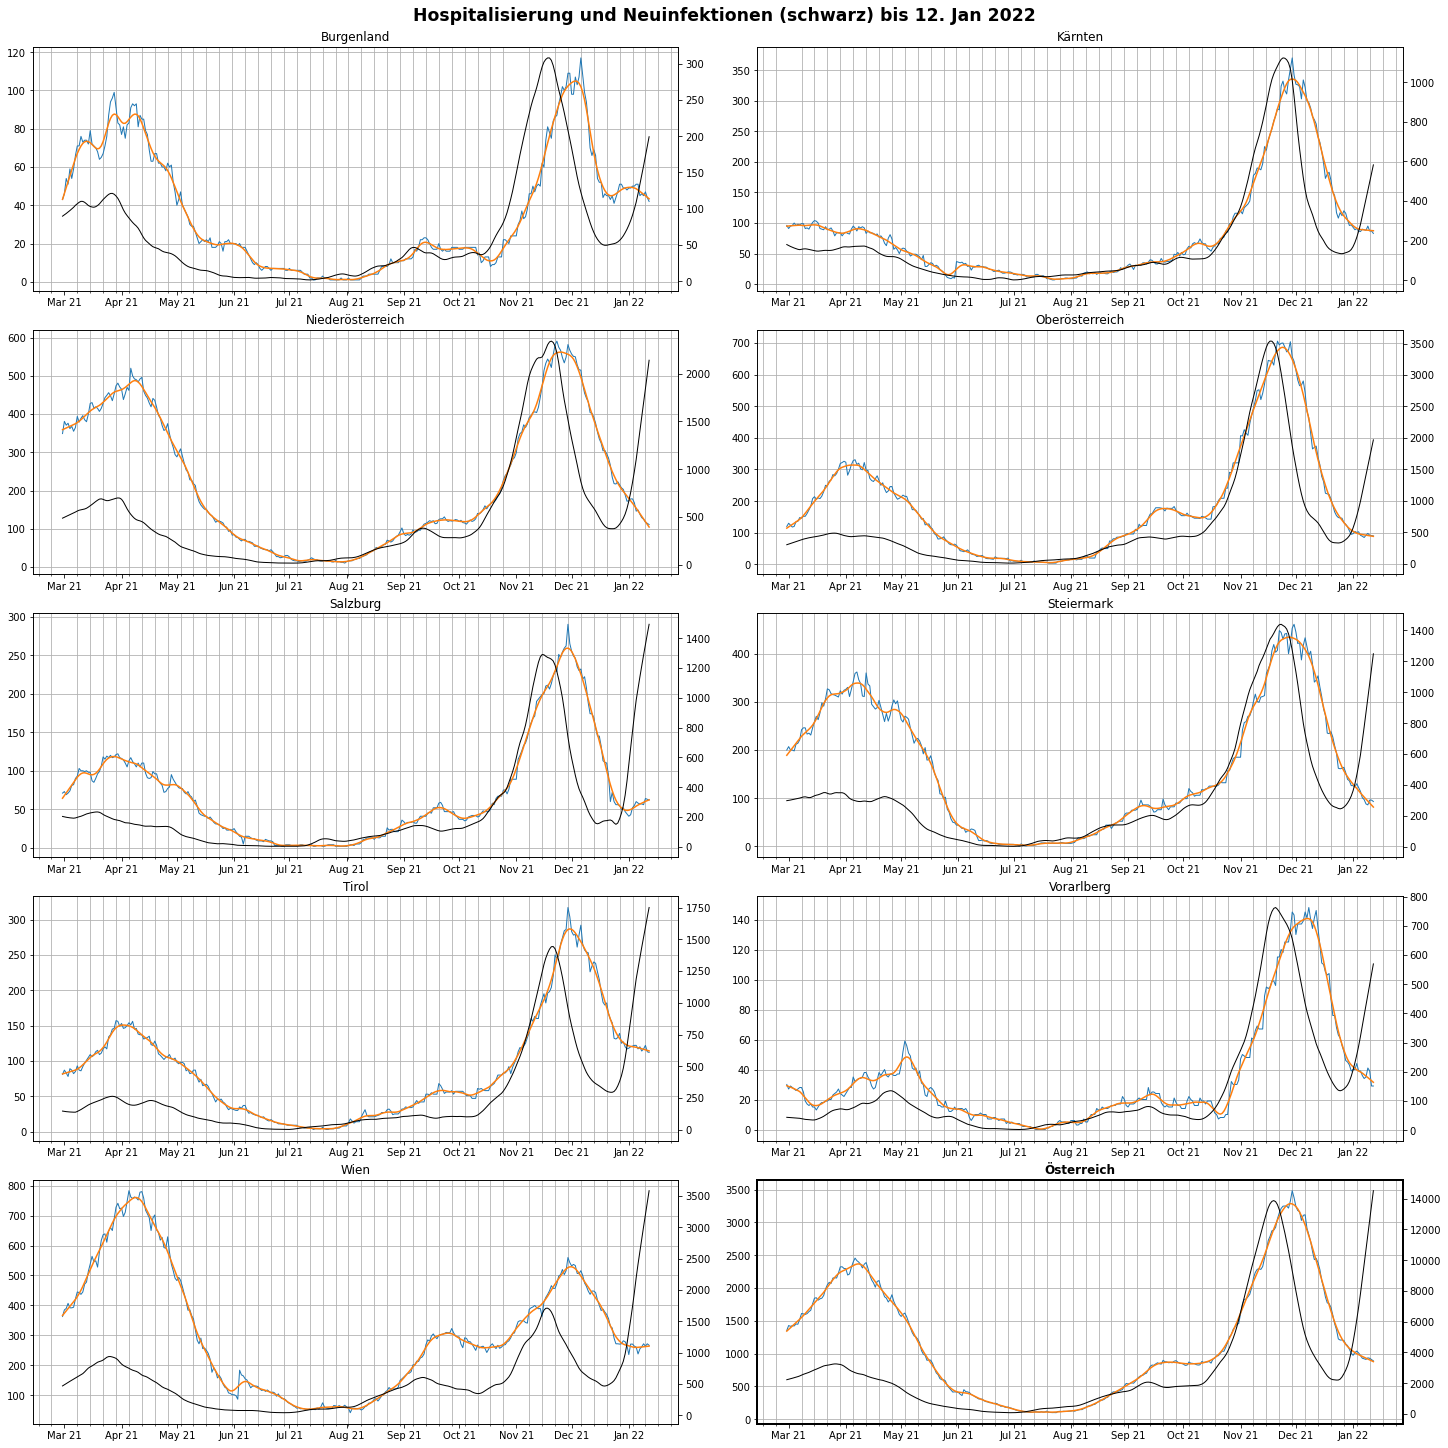

In [8]:

plot_param(["Hospitalisierung", "Neuinfektionen"],
           "Hospitalisierung und Neuinfektionen (schwarz)", data)


## Durchgeführte PCR Tests
### Werte der letzten 7 Tage

In [9]:
data.tail(7*10).pivot(values="TestungenPCRTaeglich", columns="Name")

Name,Burgenland,Kärnten,Niederösterreich,Oberösterreich,Salzburg,Steiermark,Tirol,Vorarlberg,Wien,Österreich
Datum,,,,,,,,,,
2022-01-06,1763.0,6731.0,16660.0,36039.0,15504.0,19757.0,14097.0,4285.0,176538.0,291374.0
2022-01-07,11365.0,1588.0,17987.0,25621.0,9499.0,25213.0,23767.0,9780.0,168579.0,418942.0
2022-01-08,1866.0,10809.0,18669.0,42277.0,24385.0,23902.0,12268.0,9780.0,228137.0,390102.0
2022-01-09,11585.0,8314.0,18838.0,43577.0,16700.0,34189.0,12268.0,10104.0,321899.0,477474.0
2022-01-10,12697.0,8265.0,19012.0,42003.0,7026.0,26207.0,24748.0,5998.0,285848.0,431804.0
2022-01-11,9000.0,7465.0,320653.0,51266.0,29020.0,7340.0,20364.0,9710.0,449766.0,904584.0
2022-01-12,10968.0,10523.0,24837.0,39784.0,25853.0,11567.0,21440.0,7754.0,253822.0,406548.0


### Diagramm

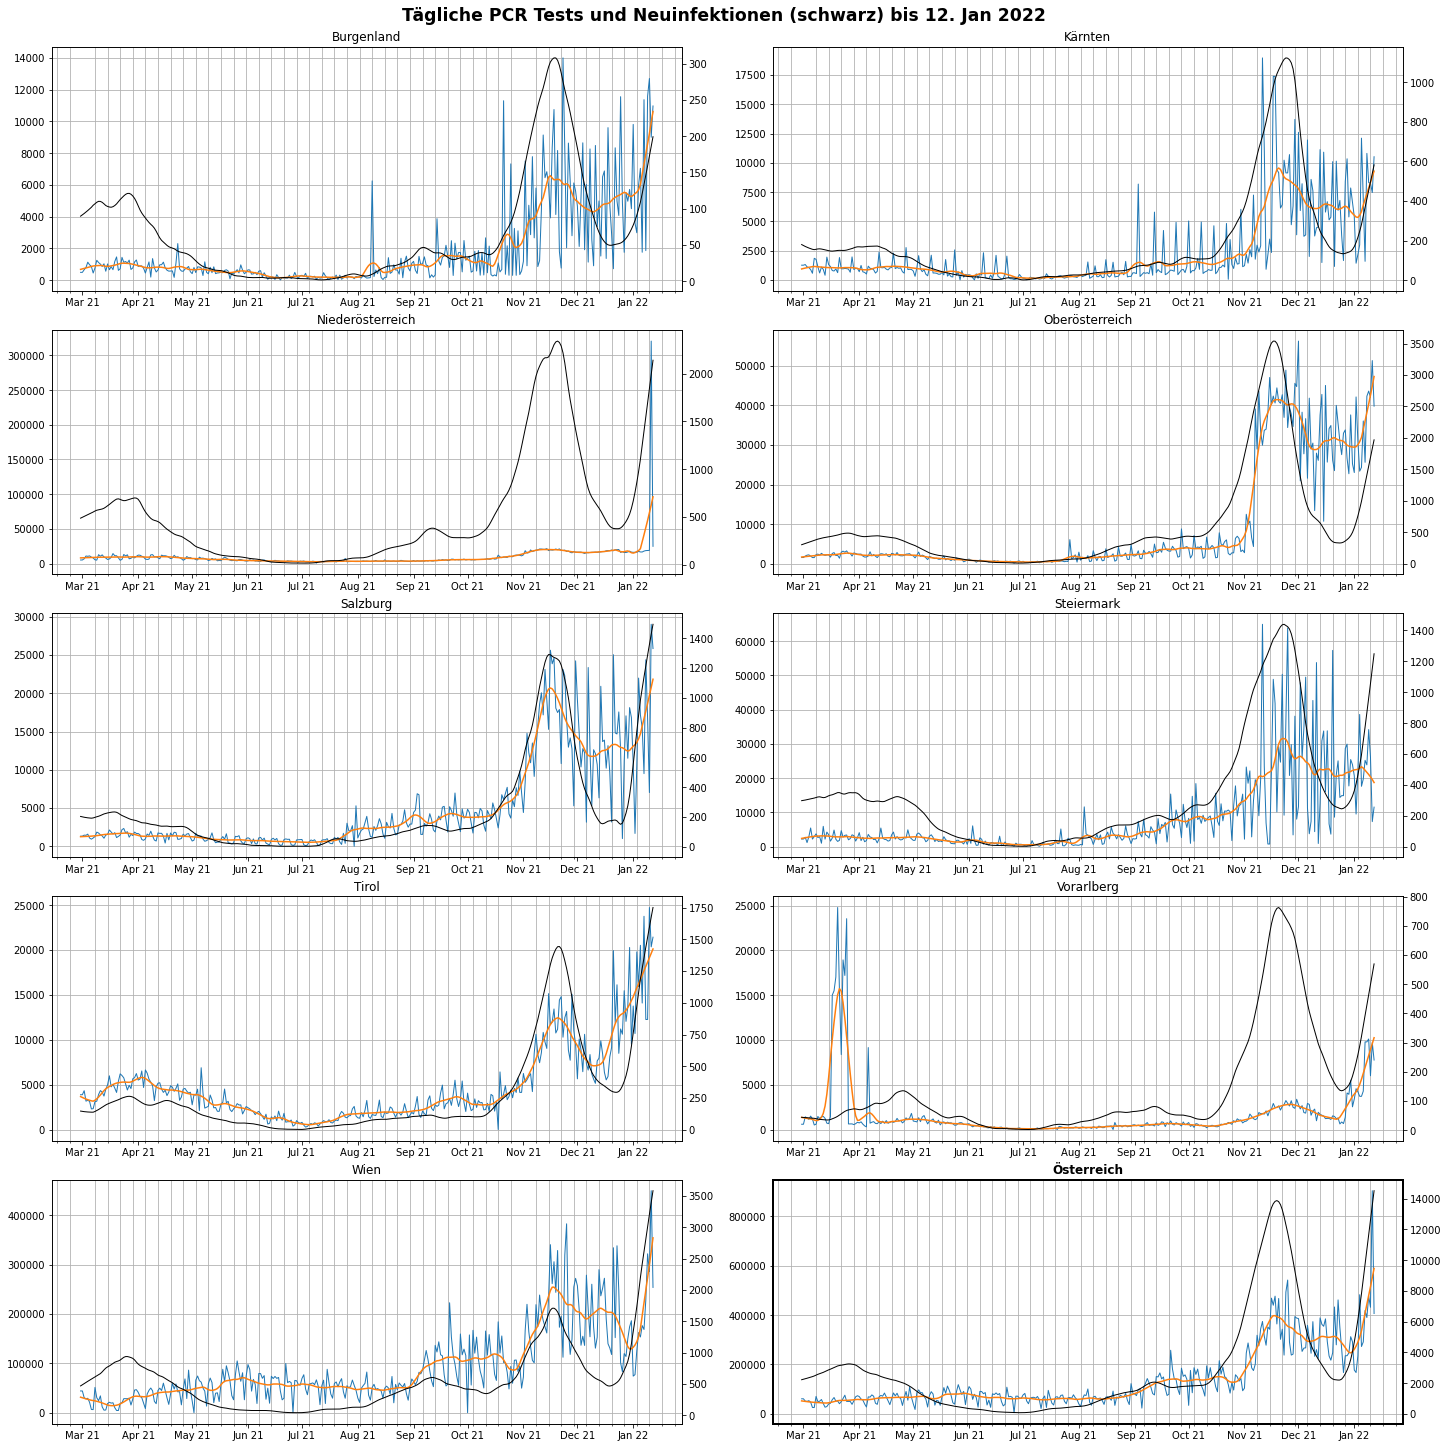

In [10]:

plot_param(["TestungenPCRTaeglich", "Neuinfektionen"], "Tägliche PCR Tests und Neuinfektionen (schwarz)", data)
